In [1]:
# --- Kaggle-safe: make sklearn + umap compatible ---
!pip -q install -U --no-deps scikit-learn==1.4.2 umap-learn==0.5.6

import os, signal
#os.kill(os.getpid(), signal.SIGKILL)   # restart so the new sklearn is actually used


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00


In [2]:
!pip uninstall -y protobuf -q
!pip install -q "protobuf==4.25.3"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have proto

In [3]:
import sklearn, umap
print("sklearn:", sklearn.__version__)
print("umap:", umap.__version__)



2025-12-16 21:29:30.333447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765920570.529457      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765920570.582696      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


sklearn: 1.4.2
umap: 0.5.6


In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import google.protobuf
print("protobuf:", google.protobuf.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


protobuf: 4.25.3
Device: cuda


In [5]:
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"


In [6]:
base_ds = datasets.ImageFolder(DATA_DIR)  # no transform yet
y_all = np.array(base_ds.targets)
n = len(base_ds)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(np.zeros(n), y_all))

train_idx = np.array(train_idx)
test_idx  = np.array(test_idx)

print("Total:", n, "Train:", len(train_idx), "Test:", len(test_idx))
print("Num classes:", len(base_ds.classes))


Total: 1016 Train: 812 Test: 204
Num classes: 11


In [7]:
# SimCLR Augmentation Recipe (documented):
# 1) RandomResizedCrop(224)
# 2) RandomHorizontalFlip
# 3) RandomRotation(20)               (microscopy-friendly)
# 4) ColorJitter (mild)
# 5) RandomGrayscale(p=0.2)
# 6) GaussianBlur(kernel_size=9)
# 7) Normalize with ImageNet stats

class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [8]:
ssl_ds = datasets.ImageFolder(DATA_DIR, transform=TwoCropsTransform(simclr_transform))
train_ssl = Subset(ssl_ds, train_idx)

train_ssl_loader = DataLoader(train_ssl, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
print("SSL train batches:", len(train_ssl_loader))


SSL train batches: 12


In [9]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=128):
        super().__init__()
        self.encoder = base_encoder
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.proj = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        h = self.encoder(x)
        z = self.proj(h)
        return F.normalize(z, dim=1)

def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)             # (2N,D)
    sim = torch.mm(z, z.t()) / temperature       # (2N,2N)
    mask = torch.eye(2*N, device=z.device, dtype=torch.bool)
    sim = sim.masked_fill(mask, -1e9)
    targets = torch.arange(2*N, device=z.device)
    targets = (targets + N) % (2*N)
    return F.cross_entropy(sim, targets)

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
ssl_model = SimCLR(resnet50).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


In [10]:
optimizer = optim.Adam(ssl_model.parameters(), lr=3e-4, weight_decay=1e-4)
epochs_ssl = 150
ssl_loss_hist = []

for epoch in range(epochs_ssl):
    ssl_model.train()
    total = 0.0
    for (xi, xj), _ in train_ssl_loader:
        xi, xj = xi.to(device), xj.to(device)
        zi = ssl_model(xi)
        zj = ssl_model(xj)
        loss = nt_xent_loss(zi, zj, temperature=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg_loss = total / len(train_ssl_loader)
    ssl_loss_hist.append(avg_loss)
    print(f"[SSL] Epoch {epoch+1}/{epochs_ssl} loss={avg_loss:.4f}")

# Save frozen encoder (requirement 5.1)
torch.save(ssl_model.encoder.state_dict(), "simclr_frozen_encoder.pt")
print("Saved: simclr_frozen_encoder.pt")


[SSL] Epoch 1/150 loss=4.0494
[SSL] Epoch 2/150 loss=3.7684
[SSL] Epoch 3/150 loss=3.6812
[SSL] Epoch 4/150 loss=3.6254
[SSL] Epoch 5/150 loss=3.5851
[SSL] Epoch 6/150 loss=3.5831
[SSL] Epoch 7/150 loss=3.5318
[SSL] Epoch 8/150 loss=3.5230
[SSL] Epoch 9/150 loss=3.5130
[SSL] Epoch 10/150 loss=3.4544
[SSL] Epoch 11/150 loss=3.4537
[SSL] Epoch 12/150 loss=3.4343
[SSL] Epoch 13/150 loss=3.4897
[SSL] Epoch 14/150 loss=3.4064
[SSL] Epoch 15/150 loss=3.4104
[SSL] Epoch 16/150 loss=3.4249
[SSL] Epoch 17/150 loss=3.4161
[SSL] Epoch 18/150 loss=3.3849
[SSL] Epoch 19/150 loss=3.3643
[SSL] Epoch 20/150 loss=3.3462
[SSL] Epoch 21/150 loss=3.3724
[SSL] Epoch 22/150 loss=3.3534
[SSL] Epoch 23/150 loss=3.3766
[SSL] Epoch 24/150 loss=3.3223
[SSL] Epoch 25/150 loss=3.3421
[SSL] Epoch 26/150 loss=3.3268
[SSL] Epoch 27/150 loss=3.3290
[SSL] Epoch 28/150 loss=3.3680
[SSL] Epoch 29/150 loss=3.3176
[SSL] Epoch 30/150 loss=3.3255
[SSL] Epoch 31/150 loss=3.3305
[SSL] Epoch 32/150 loss=3.3362
[SSL] Epoch 33/15

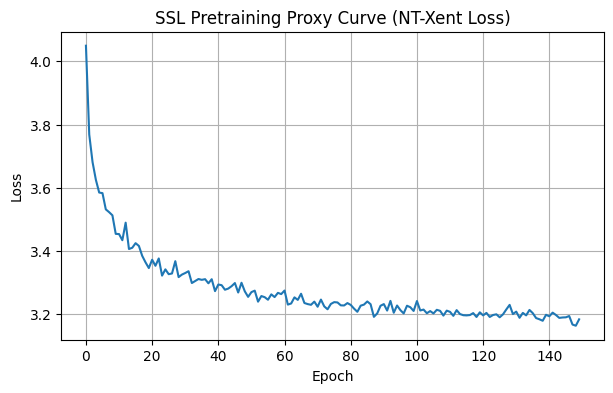

In [11]:
plt.figure(figsize=(7,4))
plt.plot(ssl_loss_hist)
plt.title("SSL Pretraining Proxy Curve (NT-Xent Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [12]:
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

probe_ds = datasets.ImageFolder(DATA_DIR, transform=eval_tf)
train_probe = Subset(probe_ds, train_idx)
test_probe  = Subset(probe_ds, test_idx)

train_probe_loader = DataLoader(train_probe, batch_size=64, shuffle=False, num_workers=2)
test_probe_loader  = DataLoader(test_probe, batch_size=64, shuffle=False, num_workers=2)

# Freeze encoder
for p in ssl_model.encoder.parameters():
    p.requires_grad = False
ssl_model.encoder.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
def extract_features(encoder, loader):
    encoder.eval()
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            f = encoder(x).cpu()
            feats.append(f)
            labels.append(y)
    return torch.cat(feats).numpy(), torch.cat(labels).numpy()

X_train, y_train = extract_features(ssl_model.encoder, train_probe_loader)
X_test,  y_test  = extract_features(ssl_model.encoder, test_probe_loader)

print("Frozen feature shape:", X_train.shape)
num_classes = len(probe_ds.classes)


Frozen feature shape: (812, 2048)


In [14]:
def per_class_accuracy(cm):
    # diag / row sum
    row_sum = cm.sum(axis=1).clip(min=1)
    return np.diag(cm) / row_sum

def eval_classifier(name, clf, Xtr, ytr, Xte, yte, plot_roc=True):
    # Train time
    t0 = time.time()
    clf.fit(Xtr, ytr)
    train_time = time.time() - t0

    # Test time
    t0 = time.time()
    ypred = clf.predict(Xte)
    test_time = time.time() - t0

    acc = accuracy_score(yte, ypred)
    cm = confusion_matrix(yte, ypred)
    pca = per_class_accuracy(cm)

    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(yte, ypred, average="weighted", zero_division=0)

    print("\n==============================")
    print(f"{name}")
    print("==============================")
    print("Accuracy:", acc)
    print("Weighted Precision:", prec_w)
    print("Weighted Recall:", rec_w)
    print("Weighted F1:", f1_w)
    print("Per-class Accuracy:", np.round(pca, 3))
    print("Train time (s):", round(train_time, 4), "Test time (s):", round(test_time, 4))
    print("Confusion Matrix:\n", cm)
    print(classification_report(yte, ypred, zero_division=0))

    # ROC-AUC (One-vs-Rest) if predict_proba exists
    if plot_roc and hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(Xte)
        y_bin = label_binarize(yte, classes=list(range(num_classes)))

        # Handle missing classes (rare but possible)
        present = y_bin.sum(axis=0) > 0
        aucs = []
        plt.figure(figsize=(7,5))
        for i in range(num_classes):
            if not present[i]:
                continue
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            auc_val = auc(fpr, tpr)
            aucs.append(auc_val)
            plt.plot(fpr, tpr, label=f"Class {i} AUC={auc_val:.3f}")

        plt.plot([0,1],[0,1],'--')
        plt.title(f"ROC Curves (OvR) — {name}")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(fontsize=8)
        plt.grid(True)
        plt.show()

        # Macro ROC-AUC (only present classes)
        macro_auc = np.mean(aucs) if len(aucs) else float("nan")
        print("Macro ROC-AUC (present classes):", macro_auc)

    return {
        "name": name,
        "acc": acc,
        "prec_w": prec_w,
        "rec_w": rec_w,
        "f1_w": f1_w,
        "train_time": train_time,
        "test_time": test_time
    }



Linear Probe (LogReg)
Accuracy: 0.7549019607843137
Weighted Precision: 0.7687549459000882
Weighted Recall: 0.7549019607843137
Weighted F1: 0.7582949617374324
Per-class Accuracy: [0.    0.81  0.852 1.    0.615 0.933 0.744 0.609 0.667 0.778 0.706]
Train time (s): 496.3829 Test time (s): 0.0133
Confusion Matrix:
 [[ 0  0  1  0  0  0  0  0  0  0  0]
 [ 0 17  1  2  0  1  0  0  0  0  0]
 [ 0  0 23  0  1  0  0  3  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  4  3  0  1  2]
 [ 0  0  0  0  1 28  1  0  0  0  0]
 [ 0  0  0  0  2  1 32  6  0  0  2]
 [ 0  0  1  0  1  0  4 14  1  1  1]
 [ 0  0  0  0  0  0  0  0  4  0  2]
 [ 0  0  0  0  0  0  1  0  1  7  0]
 [ 0  0  0  0  1  1  0  3  0  0 12]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.81      0.89        21
           2       0.88      0.85      0.87        27
           3       0.33      1.00      0.50         1
           4       

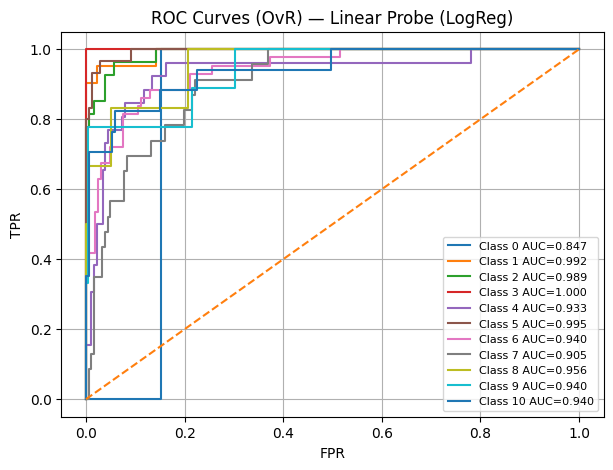

Macro ROC-AUC (present classes): 0.9488911873965051


In [15]:
linear_probe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, solver="saga")  # sklearn>=1.4: no multi_class arg
)

res_linear = eval_classifier("Linear Probe (LogReg)", linear_probe, X_train, y_train, X_test, y_test, plot_roc=True)



Shallow Head: MLP
Accuracy: 0.6862745098039216
Weighted Precision: 0.6783727706736252
Weighted Recall: 0.6862745098039216
Weighted F1: 0.67776256313311
Per-class Accuracy: [0.    0.905 0.815 1.    0.538 0.933 0.581 0.478 0.667 0.778 0.529]
Train time (s): 4.7059 Test time (s): 0.0079
Confusion Matrix:
 [[ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0 19  1  0  0  1  0  0  0  0  0]
 [ 0  0 22  0  0  0  2  3  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0 14  2  3  3  0  1  2]
 [ 0  0  0  0  1 28  1  0  0  0  0]
 [ 0  3  3  0  5  4 25  1  0  0  2]
 [ 0  0  1  0  1  1  7 11  0  1  1]
 [ 0  0  0  0  0  2  0  0  4  0  0]
 [ 0  0  0  0  0  0  1  0  1  7  0]
 [ 0  0  0  0  1  3  0  4  0  0  9]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.83      0.90      0.86        21
           2       0.79      0.81      0.80        27
           3       1.00      1.00      1.00         1
           4       0.64    

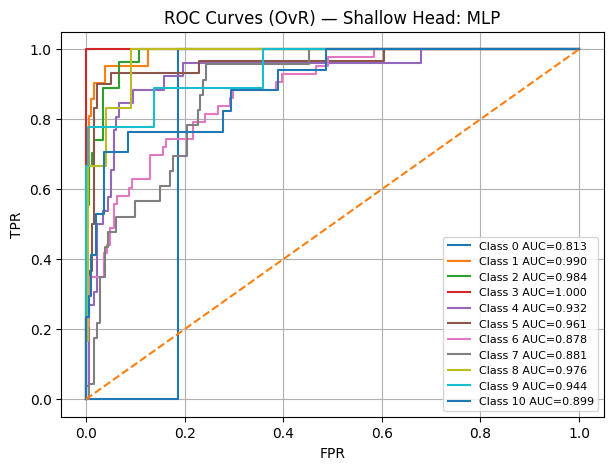

Macro ROC-AUC (present classes): 0.9324857406218571

Shallow Head: SVM (RBF)
Accuracy: 0.696078431372549
Weighted Precision: 0.7055443315846263
Weighted Recall: 0.696078431372549
Weighted F1: 0.6967743910183712
Per-class Accuracy: [0.    0.857 0.778 1.    0.538 0.933 0.605 0.565 0.667 0.778 0.588]
Train time (s): 2.8909 Test time (s): 0.2108
Confusion Matrix:
 [[ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0 18  1  1  0  0  1  0  0  0  0]
 [ 0  0 21  0  0  0  3  3  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  3  6  0  1  2]
 [ 0  0  0  0  1 28  1  0  0  0  0]
 [ 0  1  3  0  3  3 26  5  0  0  2]
 [ 0  0  0  0  1  1  7 13  0  0  1]
 [ 0  0  0  0  0  0  1  0  4  0  1]
 [ 0  0  0  0  0  0  1  0  1  7  0]
 [ 0  0  0  0  1  2  0  4  0  0 10]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      0.86      0.88        21
           2       0.84      0.78      0.81        27
           3       0.50

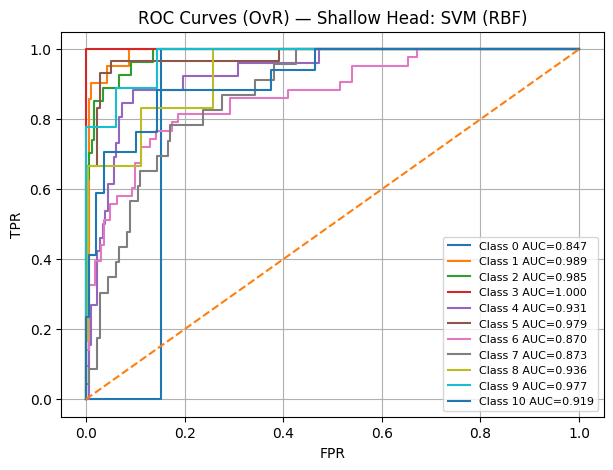

Macro ROC-AUC (present classes): 0.9368655822763393

Shallow Head: Decision Tree
Accuracy: 0.5637254901960784
Weighted Precision: 0.5639480657127716
Weighted Recall: 0.5637254901960784
Weighted F1: 0.5612415259332076
Per-class Accuracy: [0.    0.667 0.741 0.    0.423 0.7   0.488 0.522 0.167 0.778 0.471]
Train time (s): 2.0664 Test time (s): 0.0007
Confusion Matrix:
 [[ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0 14  4  0  1  0  0  2  0  0  0]
 [ 0  0 20  0  0  0  3  2  0  0  2]
 [ 0  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  3  0 11  2  2  4  0  1  2]
 [ 0  1  1  0  1 21  3  0  1  0  2]
 [ 0  5  3  1  6  2 21  3  1  0  1]
 [ 0  0  2  0  3  1  4 12  0  1  0]
 [ 0  0  1  0  0  0  2  0  1  0  2]
 [ 0  0  0  0  0  0  1  0  1  7  0]
 [ 0  0  1  1  3  2  1  0  1  0  8]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.67      0.67        21
           2       0.56      0.74      0.63        27
           3     

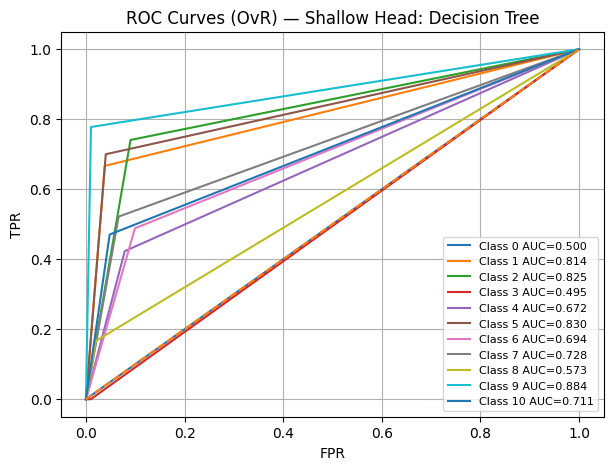

Macro ROC-AUC (present classes): 0.7024538001318995

Shallow Head: Random Forest
Accuracy: 0.6813725490196079
Weighted Precision: 0.6906891236886912
Weighted Recall: 0.6813725490196079
Weighted F1: 0.67976577293174
Per-class Accuracy: [0.    0.857 0.815 0.    0.423 0.833 0.674 0.609 0.667 0.778 0.529]
Train time (s): 8.8052 Test time (s): 0.0225
Confusion Matrix:
 [[ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0 18  1  0  0  0  2  0  0  0  0]
 [ 0  0 22  0  1  0  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 11  1  4  6  0  1  3]
 [ 0  0  0  0  1 25  4  0  0  0  0]
 [ 0  2  2  0  2  1 29  6  0  0  1]
 [ 0  0  0  0  1  0  8 14  0  0  0]
 [ 0  0  0  0  0  0  1  0  4  0  1]
 [ 0  0  0  0  0  0  1  0  1  7  0]
 [ 0  0  0  0  1  2  0  4  1  0  9]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.86      0.86        21
           2       0.88      0.81      0.85        27
           3       

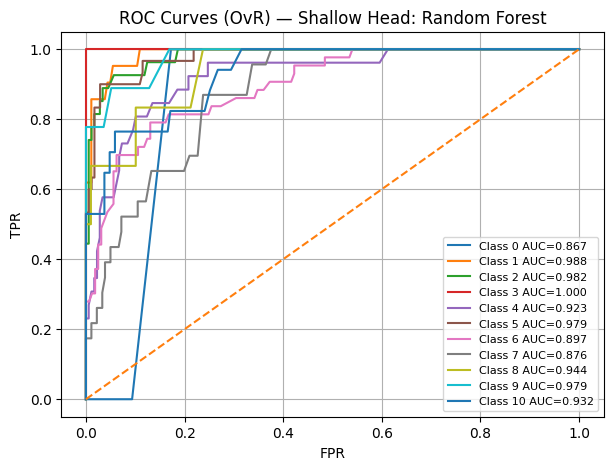

Macro ROC-AUC (present classes): 0.9423281596985622


In [16]:
shallow_results = []

mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(512,), max_iter=200, random_state=42)
)
shallow_results.append(eval_classifier("Shallow Head: MLP", mlp, X_train, y_train, X_test, y_test, plot_roc=True))

svm = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", C=10.0, gamma="scale", probability=True, random_state=42)
)
shallow_results.append(eval_classifier("Shallow Head: SVM (RBF)", svm, X_train, y_train, X_test, y_test, plot_roc=True))

dt = DecisionTreeClassifier(max_depth=None, random_state=42)
shallow_results.append(eval_classifier("Shallow Head: Decision Tree", dt, X_train, y_train, X_test, y_test, plot_roc=True))

rf = RandomForestClassifier(n_estimators=300, random_state=42)
shallow_results.append(eval_classifier("Shallow Head: Random Forest", rf, X_train, y_train, X_test, y_test, plot_roc=True))


In [17]:
for k in [1, 5, 20]:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    print(f"kNN (k={k}) Accuracy:", accuracy_score(y_test, pred))


kNN (k=1) Accuracy: 0.6078431372549019
kNN (k=5) Accuracy: 0.5735294117647058
kNN (k=20) Accuracy: 0.5784313725490197


[FT] Epoch 1/20 loss=1.5088 train_acc=0.6613 test_acc=0.6029
[FT] Epoch 2/20 loss=0.9719 train_acc=0.7500 test_acc=0.6520
[FT] Epoch 3/20 loss=0.8228 train_acc=0.7943 test_acc=0.6422
[FT] Epoch 4/20 loss=0.7499 train_acc=0.7377 test_acc=0.6422
[FT] Epoch 5/20 loss=0.5515 train_acc=0.8756 test_acc=0.7647
[FT] Epoch 6/20 loss=0.4928 train_acc=0.8411 test_acc=0.7353
[FT] Epoch 7/20 loss=0.5301 train_acc=0.8436 test_acc=0.6912
[FT] Epoch 8/20 loss=0.4166 train_acc=0.8855 test_acc=0.7990
[FT] Epoch 9/20 loss=0.3727 train_acc=0.8768 test_acc=0.7157
[FT] Epoch 10/20 loss=0.3708 train_acc=0.8929 test_acc=0.7549
[FT] Epoch 11/20 loss=0.3155 train_acc=0.8855 test_acc=0.7255
[FT] Epoch 12/20 loss=0.3388 train_acc=0.9360 test_acc=0.7549
[FT] Epoch 13/20 loss=0.3232 train_acc=0.9335 test_acc=0.8137
[FT] Epoch 14/20 loss=0.2935 train_acc=0.9126 test_acc=0.7598
[FT] Epoch 15/20 loss=0.2480 train_acc=0.9273 test_acc=0.7108
[FT] Epoch 16/20 loss=0.2119 train_acc=0.9212 test_acc=0.7892
[FT] Epoch 17/20 

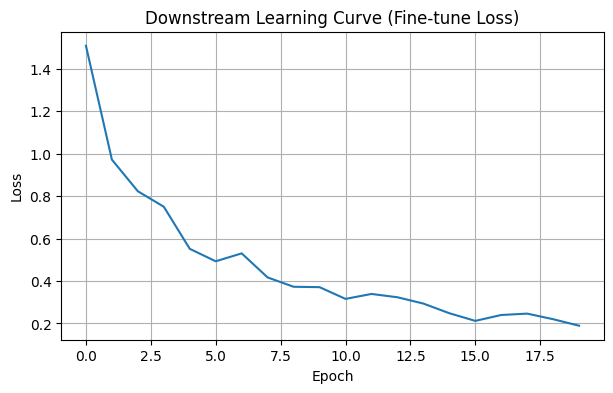

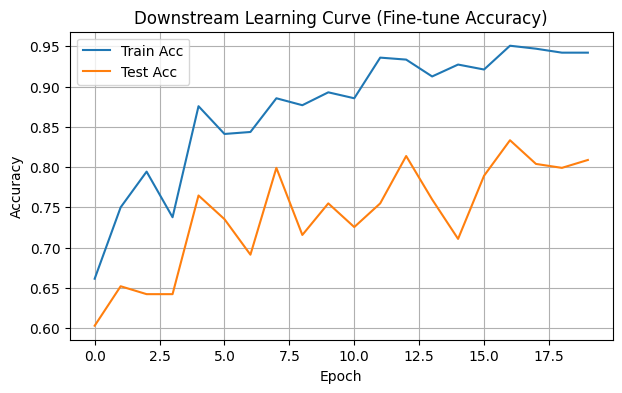

Fine-tune Accuracy: 0.8088235294117647
[[ 0  0  0  0  0  1  0  0  0  0  0]
 [ 0 16  1  0  0  1  3  0  0  0  0]
 [ 0  0 27  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  1  0  0  1  2]
 [ 0  0  2  0  0 23  4  0  0  1  0]
 [ 0  0  0  0  0  1 41  1  0  0  0]
 [ 0  0  0  0  3  1  7 11  0  1  0]
 [ 0  0  0  0  0  0  0  0  5  0  1]
 [ 0  0  0  0  0  0  0  1  1  7  0]
 [ 0  0  2  0  0  0  2  0  0  0 13]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.94      0.76      0.84        21
           2       0.84      1.00      0.92        27
           3       0.00      0.00      0.00         1
           4       0.88      0.85      0.86        26
           5       0.85      0.77      0.81        30
           6       0.71      0.95      0.81        43
           7       0.85      0.48      0.61        23
           8       0.83      0.83      0.83         6
           9       0.70

In [18]:
# Build finetune model: encoder + linear head
class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(2048, num_classes)
    def forward(self, x):
        f = self.encoder(x)
        return self.head(f)

# Create finetune datasets (supervised transform for training)
finetune_train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ft_ds = datasets.ImageFolder(DATA_DIR, transform=finetune_train_tf)
test_ft_ds  = datasets.ImageFolder(DATA_DIR, transform=eval_tf)

train_ft = Subset(train_ft_ds, train_idx)
test_ft  = Subset(test_ft_ds, test_idx)

train_ft_loader = DataLoader(train_ft, batch_size=32, shuffle=True, num_workers=2)
test_ft_loader  = DataLoader(test_ft, batch_size=32, shuffle=False, num_workers=2)

# Load frozen encoder weights (safety) and start finetuning from SSL encoder
encoder_ft = models.resnet50(weights=None)
encoder_ft.fc = nn.Identity()
encoder_ft.load_state_dict(torch.load("simclr_frozen_encoder.pt", map_location="cpu"))
encoder_ft = encoder_ft.to(device)

ft_model = FineTuneModel(encoder_ft, num_classes).to(device)

# Unfreeze strategy: fine-tune all (best accuracy), or only last block for cheaper training
for p in ft_model.encoder.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ft_model.parameters(), lr=3e-4, weight_decay=1e-4)

def torch_eval(model, loader):
    model.eval()
    correct, total = 0, 0
    ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            ys.append(y.cpu().numpy())
            ps.append(pred.cpu().numpy())
    return correct/total, np.concatenate(ys), np.concatenate(ps)

epochs_ft = 20
train_acc_hist, test_acc_hist, train_loss_hist = [], [], []

t0_train = time.time()
for epoch in range(epochs_ft):
    ft_model.train()
    total_loss = 0.0

    for x, y in train_ft_loader:
        x, y = x.to(device), y.to(device)
        loss = criterion(ft_model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Train acc proxy on a small pass (quick)
    tr_acc, _, _ = torch_eval(ft_model, train_ft_loader)
    te_acc, yt, yp = torch_eval(ft_model, test_ft_loader)

    train_loss_hist.append(total_loss / len(train_ft_loader))
    train_acc_hist.append(tr_acc)
    test_acc_hist.append(te_acc)

    print(f"[FT] Epoch {epoch+1}/{epochs_ft} loss={train_loss_hist[-1]:.4f} train_acc={tr_acc:.4f} test_acc={te_acc:.4f}")

ft_train_time = time.time() - t0_train

# inference time
t0 = time.time()
_ = torch_eval(ft_model, test_ft_loader)
ft_test_time = time.time() - t0

print("Fine-tune total train time (s):", round(ft_train_time, 2))
print("Fine-tune test eval time (s):", round(ft_test_time, 4))

# Downstream learning curves
plt.figure(figsize=(7,4))
plt.plot(train_loss_hist)
plt.title("Downstream Learning Curve (Fine-tune Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(test_acc_hist, label="Test Acc")
plt.title("Downstream Learning Curve (Fine-tune Accuracy)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Final fine-tune report
ft_acc, yt, yp = torch_eval(ft_model, test_ft_loader)
print("Fine-tune Accuracy:", ft_acc)
print(confusion_matrix(yt, yp))
print(classification_report(yt, yp, zero_division=0))


1% labels → Accuracy: 0.2255
5% labels → Accuracy: 0.3676
10% labels → Accuracy: 0.5049
25% labels → Accuracy: 0.6324
50% labels → Accuracy: 0.6863


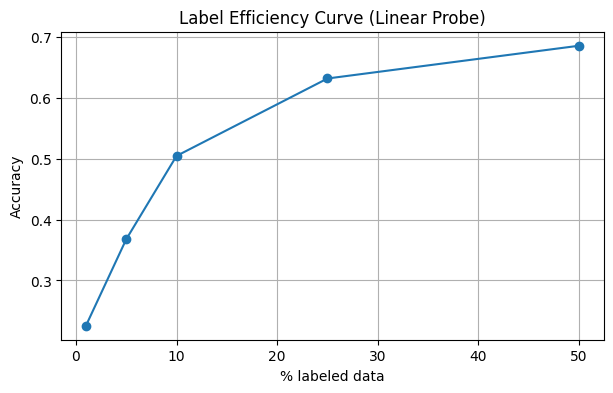

In [19]:
ratios = [0.01, 0.05, 0.10, 0.25, 0.50]
rng = np.random.default_rng(42)

eff_results = {}
classes = np.unique(y_train)

for r in ratios:
    X_small, y_small = [], []
    for c in classes:
        idx_c = np.where(y_train == c)[0]
        m = max(1, int(len(idx_c) * r))
        chosen = rng.choice(idx_c, m, replace=False)
        X_small.append(X_train[chosen])
        y_small.append(y_train[chosen])

    X_small = np.vstack(X_small)
    y_small = np.hstack(y_small)

    clf_eff = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver="saga"))
    clf_eff.fit(X_small, y_small)
    acc = clf_eff.score(X_test, y_test)
    eff_results[r] = acc
    print(f"{int(r*100)}% labels → Accuracy: {acc:.4f}")

plt.figure(figsize=(7,4))
plt.plot([r*100 for r in ratios], [eff_results[r] for r in ratios], marker="o")
plt.title("Label Efficiency Curve (Linear Probe)")
plt.xlabel("% labeled data")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


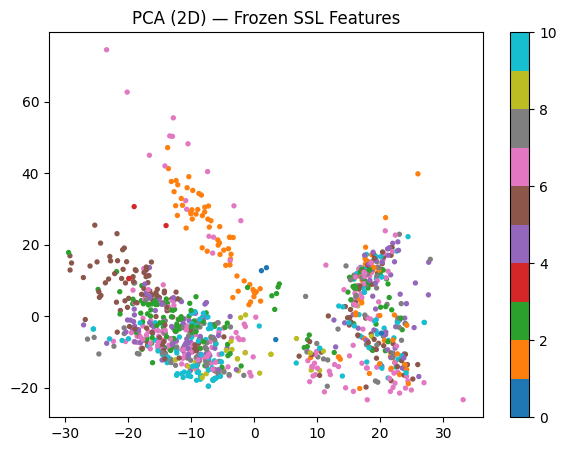

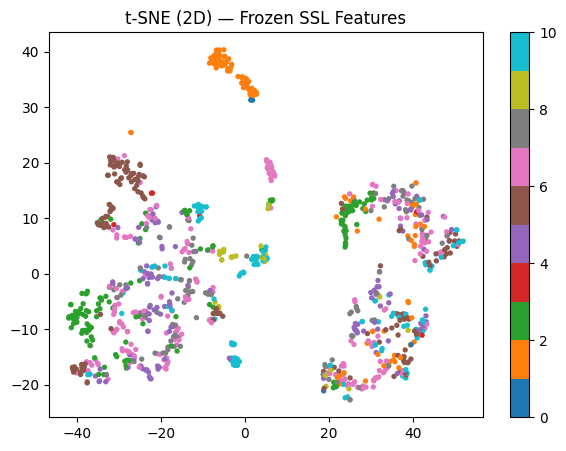

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


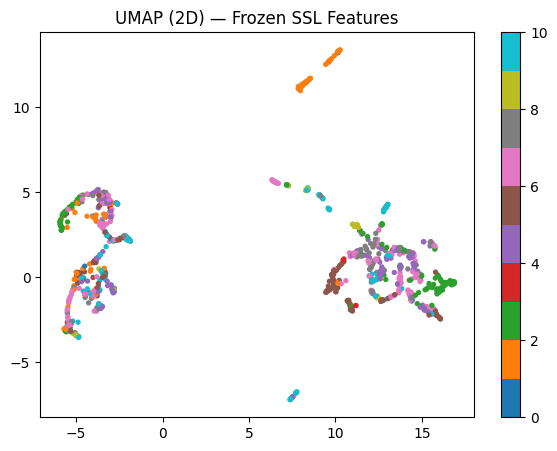

Silhouette Score: -0.012940081


In [20]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap_
import matplotlib.pyplot as plt
import numpy as np

# Combine embeddings
X_emb = np.concatenate([X_train, X_test], axis=0)
y_emb = np.concatenate([y_train, y_test], axis=0)

# Scale
X_scaled = StandardScaler().fit_transform(X_emb).astype(np.float32)

# PCA
pca = PCA(n_components=2, random_state=42)
pca_res = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(pca_res[:,0], pca_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("PCA (2D) — Frozen SSL Features")
plt.colorbar()
plt.show()

# t-SNE (slower)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
tsne_res = tsne.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("t-SNE (2D) — Frozen SSL Features")
plt.colorbar()
plt.show()

# UMAP (fixed)
um = umap_.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
um_res = um.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(um_res[:,0], um_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("UMAP (2D) — Frozen SSL Features")
plt.colorbar()
plt.show()

# Silhouette score
sil = silhouette_score(X_scaled, y_emb, metric="euclidean")
print("Silhouette Score:", sil)


In [21]:
!pip install thop -q
from thop import profile

dummy = torch.randn(1,3,224,224).to(device)

# Frozen encoder GFLOPs
macs_enc, params_enc = profile(ssl_model.encoder, inputs=(dummy,), verbose=False)
print("Frozen Encoder GFLOPs:", macs_enc/1e9)
print("Frozen Encoder Params (M):", params_enc/1e6)

# Fine-tune model GFLOPs (encoder+head)
macs_ft, params_ft = profile(ft_model, inputs=(dummy,), verbose=False)
print("Fine-tune Model GFLOPs:", macs_ft/1e9)
print("Fine-tune Model Params (M):", params_ft/1e6)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requ

In [22]:
from pandas import DataFrame

# Fill these after running each SSL method notebook (SimCLR, BYOL, MoCo, etc.)
rows = [
    {
        "SSL Method": "SimCLR",
        "Linear Probe Acc": res_linear["acc"],
        "Fine-tune Acc": float(ft_acc),
        "kNN@5 Acc": float(make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)).fit(X_train, y_train).score(X_test, y_test)),
        "Silhouette": float(sil),
        "Encoder GFLOPs": float(macs_enc/1e9),
        "Encoder Params(M)": float(params_enc/1e6),
        "Linear Probe Train Time(s)": float(res_linear["train_time"]),
        "Linear Probe Test Time(s)": float(res_linear["test_time"]),
    },
    # Add rows here for other SSL methods after you run them in separate notebooks
]

df = DataFrame(rows)
df


,SSL Method,Linear Probe Acc,Fine-tune Acc,kNN@5 Acc,Silhouette,Encoder GFLOPs,Encoder Params(M),Linear Probe Train Time(s),Linear Probe Test Time(s)
0,SimCLR,0.754902,0.808824,0.573529,-0.01294,4.131695,23.508032,496.38286,0.013343
